# ME5413 Homework 3: Planning

## Task 0: Map loading


In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-3-91d4ac49db9b>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
<ipython-input-3-91d4ac49db9b>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


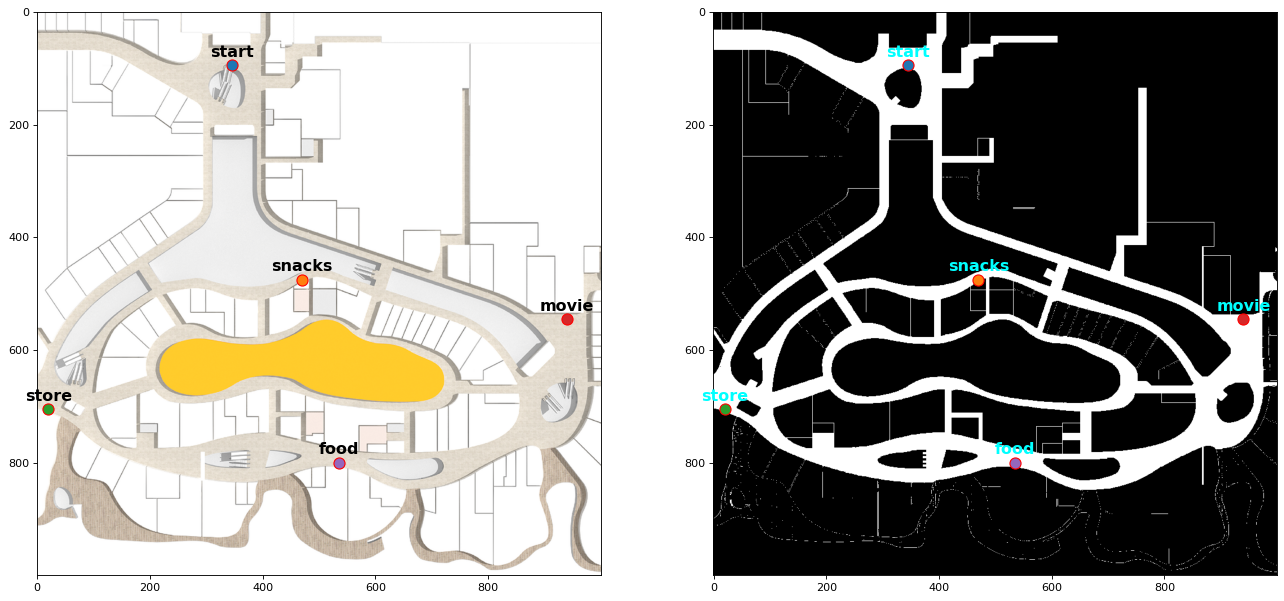

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [3]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

`A*

In [5]:
import heapq
import time
from scipy.ndimage import binary_dilation # for inflating map

# Map resolution (Constant)
STRAIGHT_COST = 0.2   # each cell represents a 0.2m x 0.2m square in reality
DIAGONAL_COST = 0.282
# human radius
R_FP = 0.3

# f = h + g
def heuristic(a, b):

    # Manhattan distance
    # return STRAIGHT_COST *abs(a[0] - b[0]) + STRAIGHT_COST *abs(a[1] - b[1])

    # Euclidean distance
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    return STRAIGHT_COST * (dx + dy) + (DIAGONAL_COST - 2 * STRAIGHT_COST) * min(dx, dy)

# A* Algorithm Implementation
def a_star(grid, start, goal):
    start_time = time.time()                                                     # recording time

    rows, cols = grid.shape
    directions = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]  # 8-connected neighbors
    open_list = []                              #  { unvisit/lesscost : cost, ... }
    heapq.heappush(open_list, (0, start))       # priority queue (realized by min-heap)

    came_from = {}                              # recording connection {  nxt : crt  ,  ...}

    visited_cells = set()
    closed_set = set()

    g_score = {start: 0}                        # cost function
    f_score = {start: heuristic(start, goal)}   # heuristic function

    while open_list:
        _, current = heapq.heappop(open_list)   # return a priority and (x,y)

        if current in closed_set:
            continue

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)

            total_distance = sum(
                DIAGONAL_COST if (path[i][0] != path[i-1][0] and path[i][1] != path[i-1][1])
                else STRAIGHT_COST
                for i in range(1, len(path))
            )
            end_time = time.time()
            total_run_time = end_time - start_time

            return path[::-1], total_distance, total_run_time, visited_cells

        closed_set.add(current)
        visited_cells.add(current)

        for d in directions:
            neighbor = (current[0] + d[0], current[1] + d[1])
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid[neighbor] == 255:   # avoid obstacle

                move_cost = DIAGONAL_COST if d[0] != 0 and d[1] != 0 else STRAIGHT_COST         # estimate move whether diagonal
                tentative_g_score = g_score[current] + move_cost

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:            # update when unvisit or find a less costly path
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))

    return None, None, None, visited_cells  # if no path


In [9]:
import itertools
# Plan paths sequentially through all locations
waypoints = ['start', 'snacks', 'store', 'movie', 'food']
all_paths = []
visited_cells = set()

# computing safe distance
def expand_obstacles(grid, safety_radius):
    expansion_radius = int(np.ceil(safety_radius / STRAIGHT_COST))  # compute how many cell need to be inflated (1.5 -> 2)
    struct = np.ones(( 2*expansion_radius+1 ,  2*expansion_radius+1 ))  # every obstacle inflate 2 cell outside (0.4m)
    expanded_grid = binary_dilation(grid == 0, structure=struct).astype(int)  # if == 0, inflate
    return (255 - expanded_grid * 255)

grid_map_expanded = expand_obstacles(grid_map, R_FP)  # get a expanded map


def solve_tsp(locations, distance_table):
    # point except start
    points = list(locations.keys())
    points.remove("start")
    best_route = None
    min_distance = float('inf')

    for perm in itertools.permutations(points):
        route = ["start"] + list(perm) + ["start"] # generate all possible path
        total = sum(distance_table[route[i]][route[i+1]] for i in range(len(route)-1)) # compute all possible length of path
        if total < min_distance:
            min_distance = total
            best_route = route
    return best_route, min_distance


def plot_optimal_route(grid_map_img, locations, best_route, path_table):
    plt.figure(figsize=(10, 5))
    plt.imshow(grid_map_img, cmap='gray')
    all_paths = []

    for i in range(len(best_route)-1):
        path = path_table.get((best_route[i], best_route[i+1]))
        if path is not None:
            all_paths.extend(path)

    for point in all_paths:
        plt.plot(point[0], point[1], 'ro', markersize=1)
    for key, value in locations.items():
        plt.plot(value[0], value[1], marker='o', markersize=8, markeredgecolor='red', markerfacecolor='yellow')
        plt.text(value[0], value[1] - 15, s=key, fontsize='large', fontweight='bold', color='cyan', ha='center')
    plt.title("Optimal Route")
    plt.show()


Total runtime (s): 3.6700079441070557
Distance Table:
from/to	start	snacks	store	movie	food
start	0	143.75	155.61	179.15	225.40
snacks	143.75	0	115.44	108.35	135.02
store	155.61	115.44	0	210.14	111.12
movie	179.15	108.35	210.14	0	113.83
food	225.40	135.02	111.12	113.83	0
Optimal Route: start -> store -> food -> movie -> snacks -> start
Total Distance (m): 632.6579999999994


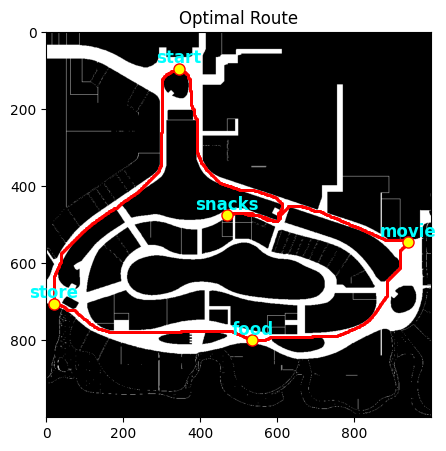

In [10]:
# Compute shortest paths between all points
distance_table = {key: {} for key in locations}
total_time =0
path_table = {}
for p1, p2 in itertools.combinations(locations.keys(), 2):
    path, dist,run_time,visited_cells = a_star(grid_map_expanded, tuple(locations[p1]), tuple(locations[p2]))
    distance_table[p1][p2] = dist
    distance_table[p2][p1] = dist  # Ensure symmetry
    total_time += run_time
    path_table[(p1, p2)] = path
    path_table[(p2, p1)] = path[::-1]


###### print distance table #######
print("Total runtime (s):", total_time)
print("Distance Table:")
headers = ['from/to'] + list(locations.keys())
print("\t".join(headers))
for key in locations:
    row = [key] + [f"{distance_table[key].get(dest, 0):.2f}" if key != dest else "0" for dest in locations]
    print("\t".join(row))
##################################

best_route, tsp_distance = solve_tsp(locations, distance_table)
print("Optimal Route:", " -> ".join(best_route))
print("Total Distance (m):", tsp_distance)

##################################

plot_optimal_route(grid_map_img, locations, best_route,path_table)

`Dijkstra's Algorithm`

In [11]:
import heapq
import time
import numpy as np

# Map resolution (Constants)
STRAIGHT_COST = 0.2   # 水平/垂直移动代价
DIAGONAL_COST = 0.282 # 对角线移动代价

def dijkstra(grid, start, goal):
    start_time = time.time()  # 记录算法开始时间

    rows, cols = grid.shape
    # 8个方向
    directions = [(0,1), (1,0), (0,-1), (-1,0),
                  (1,1), (1,-1), (-1,1), (-1,-1)]

    open_list = []  # 优先队列，存放 (g_score, 节点)
    heapq.heappush(open_list, (0, start))

    came_from = {}   # 记录路径 { neighbor : current }
    closed_set = set()       # 记录已扩展的节点
    visited_cells = set()    # 用于统计访问过的节点
    g_score = {start: 0}     # 从起点到每个节点的实际代价

    while open_list:
        current_cost, current = heapq.heappop(open_list)

        if current in closed_set:
            continue
        closed_set.add(current)
        visited_cells.add(current)

        # 如果到达目标，重构路径
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path = path[::-1]

            # 精确计算总行驶距离
            total_distance = 0
            for i in range(1, len(path)):
                # 判断水平/竖直或对角线移动
                if path[i][0] == path[i-1][0] or path[i][1] == path[i-1][1]:
                    step_cost = STRAIGHT_COST
                else:
                    step_cost = DIAGONAL_COST
                total_distance += step_cost

            total_run_time = time.time() - start_time
            return path, total_distance, total_run_time, visited_cells

        for d in directions:
            neighbor = (current[0] + d[0], current[1] + d[1])
            # 检查边界和障碍物
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid[neighbor] == 255:
                # 对角线运动的障碍物检测：防止“斜穿角”
                if d[0] != 0 and d[1] != 0:
                    adjacent1 = (current[0] + d[0], current[1])
                    adjacent2 = (current[0], current[1] + d[1])
                    if not (0 <= adjacent1[0] < rows and 0 <= adjacent1[1] < cols and grid[adjacent1] == 255):
                        continue
                    if not (0 <= adjacent2[0] < rows and 0 <= adjacent2[1] < cols and grid[adjacent2] == 255):
                        continue

                move_cost = DIAGONAL_COST if (d[0] != 0 and d[1] != 0) else STRAIGHT_COST
                tentative_g_score = g_score[current] + move_cost

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    heapq.heappush(open_list, (tentative_g_score, neighbor))

    return None, None, None, visited_cells  # 无法到达目标时返回


Total runtime (s): 10.05579948425293
Distance Table:
from/to	start	snacks	store	movie	food
start	0	144.23	155.97	179.38	226.11
snacks	144.23	0	115.68	108.58	135.73
store	155.97	115.68	0	210.26	111.12
movie	179.38	108.58	210.26	0	113.95
food	226.11	135.73	111.12	113.95	0
Optimal Route: start -> snacks -> movie -> food -> store -> start
Total Distance (m): 633.8379999999995


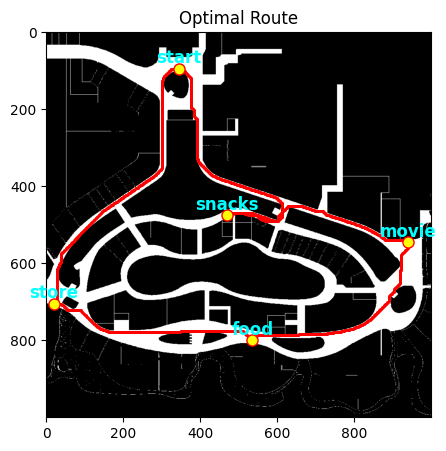

In [12]:
# Compute shortest paths between all points
distance_table = {key: {} for key in locations}
total_time =0
path_table = {}
for p1, p2 in itertools.combinations(locations.keys(), 2):
    path, dist,run_time,visited_cells = dijkstra(grid_map_expanded, tuple(locations[p1]), tuple(locations[p2]))
    distance_table[p1][p2] = dist
    distance_table[p2][p1] = dist  # Ensure symmetry
    total_time += run_time
    path_table[(p1, p2)] = path
    path_table[(p2, p1)] = path[::-1]


###### print distance table #######
print("Total runtime (s):", total_time)
print("Distance Table:")
headers = ['from/to'] + list(locations.keys())
print("\t".join(headers))
for key in locations:
    row = [key] + [f"{distance_table[key].get(dest, 0):.2f}" if key != dest else "0" for dest in locations]
    print("\t".join(row))
##################################

best_route, tsp_distance = solve_tsp(locations, distance_table)
print("Optimal Route:", " -> ".join(best_route))
print("Total Distance (m):", tsp_distance)

##################################

plot_optimal_route(grid_map_img, locations, best_route,path_table)

## Task 2

In [13]:
def solve_tsp_greedy(locations, distance_table):
    unvisited = set(locations.keys())
    unvisited.remove("start")
    current = "start"
    route = ["start"]
    total_distance = 0

    while unvisited:
        # Select the nearest unvisited point for the current point each time
        next_point = min(unvisited, key=lambda p: distance_table[current][p])
        total_distance += distance_table[current][next_point]
        route.append(next_point)
        unvisited.remove(next_point)
        current = next_point

    # back start point
    total_distance += distance_table[current]["start"]
    route.append("start")

    return route, total_distance

In [14]:
distance_table = {
    "start": {"start": 0, "snacks": 143.75, "store": 155.61, "movie": 179.15, "food": 225.76},
    "snacks": {"start": 143.75, "snacks": 0, "store": 115.44, "movie": 108.35, "food": 135.02},
    "store": {"start": 155.61, "snacks": 115.44, "store": 0, "movie": 210.14, "food": 111.12},
    "movie": {"start": 179.15, "snacks": 108.35, "store": 210.14, "movie": 0, "food": 113.83},
    "food": {"start": 225.76, "snacks": 135.02, "store": 111.12, "movie": 113.83, "food": 0},
}


In [15]:
tsp_time_list = []
for i in range(100000):
    start_time = time.time()
    best_route, tsp_distance = solve_tsp(locations, distance_table)
    tsp_time = time.time() - start_time
    tsp_time_list.append(tsp_time)

print("Runtime (s):", np.mean(tsp_time_list))
print("Optimal Route:", " -> ".join(best_route))
print("Total Distance (m):", tsp_distance)

# plot_optimal_route(grid_map_img, locations, best_route,path_table)

Runtime (s): 6.527727127075195e-05
Optimal Route: start -> store -> food -> movie -> snacks -> start
Total Distance (m): 632.66


Runtime (s): 4.416203498840332e-06
Optimal Route: start -> snacks -> movie -> food -> store -> start
Total Distance (m): 632.6600000000001


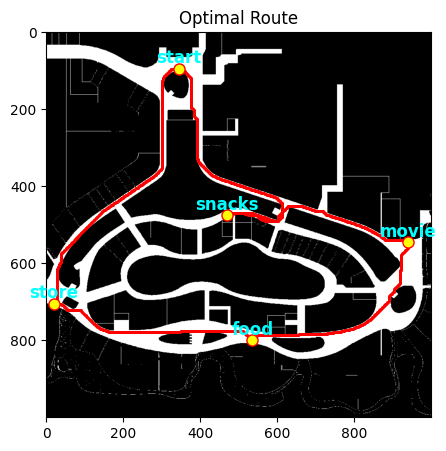

In [16]:
tsp_time_list = []
for i in range(100000):
    start_time = time.time()
    best_route, tsp_distance = solve_tsp_greedy(locations, distance_table)
    tsp_time = time.time() - start_time
    tsp_time_list.append(tsp_time)

print("Runtime (s):", np.mean(tsp_time_list))
print("Optimal Route:", " -> ".join(best_route))
print("Total Distance (m):", tsp_distance)
plot_optimal_route(grid_map_img, locations, best_route,path_table)

## Task 3
https://github.com/Zhou-Tianli/ME5413-Autonomous-Mobile-Robotics-Homework-3-Planning